Makemore is a character level language model

A character level language model predicts characters given a sequence of characters before it

For each word, each character gives the probability of that character occuring given the previous characters

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
with open(r"names.txt",'r') as f:
    words = [i.strip('\n') for i in f.readlines()]


Building a BiGram language model

We are always dealing with 2 characters at a time in a BiGram Language model. 

We are looking at one character given the single previous character

In [3]:
for w in words[:1]:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1,ch2 in zip(chs,chs[1:]):
        print(ch1,ch2)

<S> e
e m
m m
m a
a <E>


We need to learn the statistics of which character is likely to follow the other characters, the simplest way to do it is by counting.

So we are going to count how many times any one of these combinations occur in the training set

Need to maintain a dictionary which maintains the counts of the bigrams

In [4]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1,ch2 in zip(chs,chs[1:]):
        bigram = (ch1,ch2)
        b[bigram] = b.get(bigram,0) + 1

It is significantly more convenient to keep this in a Two dimensional array instead of a bigram.

The rows are going to be the first character while the columns are going to be the second character. Each entry is the count

In [5]:
#as we are using counts, we want int
#As we have 26 alphabet letters and 2 special characters we want 28x28 array
N = torch.zeros(size = (27,27),dtype = torch.int32)

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
# stoi['<E>'] = 27

In [7]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1,ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1,ix2] += 1

(-0.5, 27.5, 27.5, -0.5)

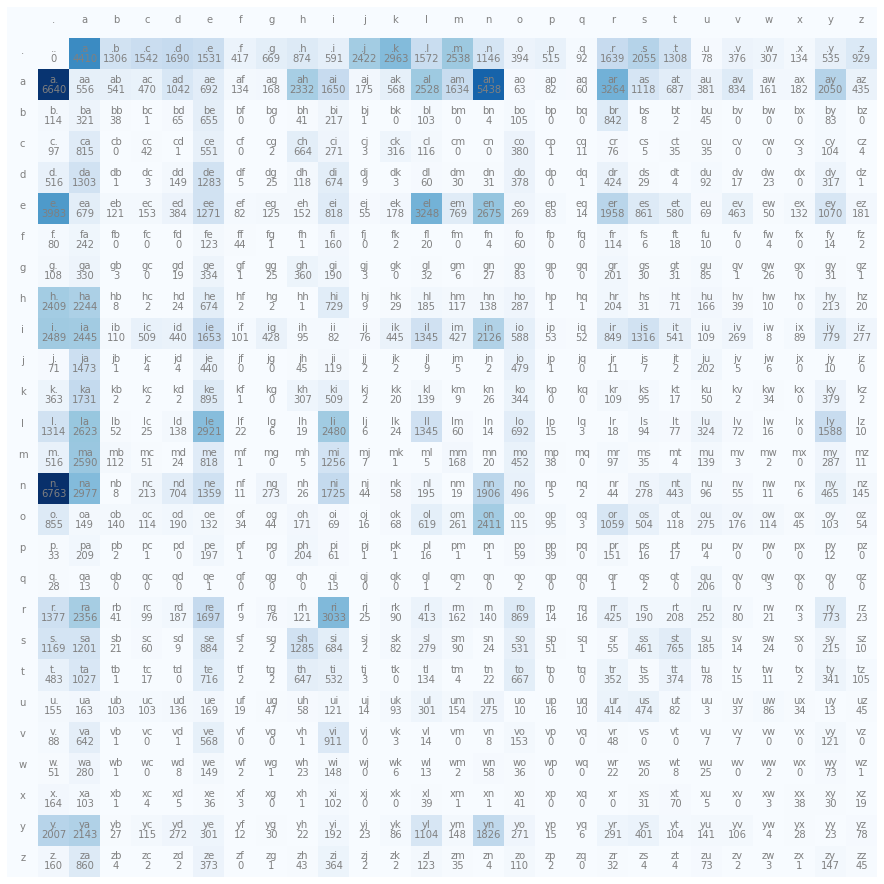

In [8]:
fig,ax = plt.subplots(1,1,figsize = (16,16))
visual_N = torch.hstack((torch.zeros(size = (27,1),dtype = torch.int32),N))
visual_N = torch.vstack((torch.zeros(size = (1,28),dtype = torch.int32),visual_N))
ax.imshow(visual_N,cmap = 'Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        ax.text(j+1,i+1,chstr,ha = 'center',va = 'bottom',color = 'gray')
        ax.text(j+1,i+1,N[i,j].item(),ha = 'center',va = 'top',color = 'gray')
for i in range(27):
    ax.text(i+1,0,itos[i],ha = 'center',color = 'gray')
    ax.text(0,i+1,itos[i],ha = 'center',color = 'gray')
ax.axis('off')

By looking at the first row of the counts, the counts are giving us how often a character starts a word by following the start token.

In [9]:
#This array gives the counts of starting words
N[0,:]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

Converting the raw counts to probabilities

In [10]:
p = N[0,:].float()/torch.sum(N[0,:])
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

Sampling from a Distribution

Use a computer to pick a random number based on the probabilities described by the histogram or the curve.

Given a normal distribution, there is a good chance the computer will pick a value from the middle where the histogram and the curve are tallest. However every now and then, the histogram will return a value from the edges where the histogram and curve are the shortest.

Sampling distribution is the distribution of a statistic made from multiple simple random samples drawn from a specific population. Essentially, a  sampling distribution is a whole bunch of stacked statistic calculated by sampling a population multiple times. 

torch.multinomial : Returns a tensor where each row contains num_samples with the indices samples from the multinomial distribution located in the row of tensor input

torch.Generator : used to make identical deterministic results

In [11]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p,num_samples=1,replacement=True,generator=g).item()
itos[ix]

'm'

In the above sampling, the word 'm' actually starts a large number of names. 

Now we can continue to sample more words. 

We look for the row that starts with m

In [12]:
p = N[ix,:].float()/torch.sum(N[ix,:])
ix = torch.multinomial(p,num_samples=1,replacement=True,generator=g).item()
itos[ix]


'o'

In [13]:
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    ix = 0
    char_list = []
    while True:
        p = N[ix,:].float()/torch.sum(N[ix,:])
        ix = torch.multinomial(p,num_samples=1,replacement=True,generator=g).item()
        # print(itos[ix])
        char_list.append(itos[ix])
        if ix == 0:
            break
    print(''.join(char_list[:-1]))

mor
axx
minaymoryles
kondlaisah
anchshizarie
odaren
iaddash
h
jhinatien
egushl
h
br
a
jayn
ilemannariaenien
be
f
akiinela
trttanakeroruceyaaxatona
lamoynayrkiedengin


In [14]:
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    ix = 0
    char_list = []
    while True:
        p = N[ix,:].float()/torch.sum(N[ix,:])
        sampling = torch.multinomial(p,num_samples=10,replacement=True,generator=g)
        ix = Counter(sampling.tolist()).most_common()[0][0]
        char_list.append(itos[ix])
        if ix == 0:
            break
    
    print(''.join(char_list[:-1]))

miliadee
in
aritonn
ke
hlon
sel
be
h
jara
a
oranan
sta
ka
kali
karan
so
kelia
maelelen
h
han


Using a uniform distribution for each p

In [15]:
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    ix = 0
    char_list = []
    while True:
        p = torch.ones(27)/27 #unform dist
        ix = torch.multinomial(p,num_samples=1,replacement=True,generator=g).item()
        # ix = Counter(sampling.tolist()).most_common()[0][0]
        char_list.append(itos[ix])
        if ix == 0:
            break
    
    print(''.join(char_list[:-1]))

qvsaayxbqrqmyqwuznivanukotdjvdhd
qnoymtzduqkatdetkpfjdgigvlejfkrsqlwnirghhzwlu
idcx
cekmzucjnjoeovjvrggqrjr
cfbhabkslpokc
xtxwbpmknuusxdgzfexhwqpldpdnwzvkyxsqjforqqpfxstwkfoufhvwfhmsuyyotvcvvqpfcbydjcouhkajkhqnnpqmmllaordqy
gszpw
zlgijinangzzuulsyvqrufuawavsdbnwvlmrypvgrsfgpshgnmwafqmsjdvbhngvoiigxhkwdltrdkwnagzyknqv
lfstdqigvncdoidetsukgdp
cfpjsxeqjcsmjwguzes
woflfjxflylgbegpjdpovdtw
dlzysqtrbhxhcdneiuum
xtyslfbmaboaanyjpojuujflcsaucqcgtjmlzqtbaisvxrtgupkppigxudejdzsroqeigovuxmvt
jlxfolkozci
tkhdivkdifaxcevlpktkwwvuxlymtwylgpzauwdvxfvbooflddphmjeomjgjcqeqwt

wlxclcjbm
quuyijtnzmycshclormjyrerqslomdrlbuwqnlmitbrmqhtbdwbyvlsmwnborwcdhjotezwnsxuvffvinrmedelubhdfgtavxqfgmnyqrygyevxaapbjtnwfnwewqxerdytttvfo
iauarz
tynoqkyp


The above is a model that is completely untrained, with no bi gram matrix

Currently we are fetching a row of N from the counts matrix. Then converting to float and dividing. Instead its better to prenormalize it

In [16]:
g = torch.Generator().manual_seed(2147483647)
P = N.float()/N.sum(dim=1)
for i in range(20):
    ix = 0
    char_list = []
    while True:
        p = P[ix,:]
        ix = torch.multinomial(p,num_samples=1,replacement=True,generator=g).item()
        # print(itos[ix])
        char_list.append(itos[ix])
        if ix == 0:
            break
    print(''.join(char_list[:-1]))


prrabuxclssoxxxxzontantorsemrdef
ppprluzavilavegunjemahekwiffffksslyndomdeyviu
jadw
chinzwamikojowivighoumo
ch
h
bismoricaysuwarliovouxigydeygwrophognuzylywttlequssphwttylequghuwelluwyzovofrusredaych
mphialigrorotopopaqudox
guzowazlelihmandyzyuppstttugububrrdaowupouxxxsstharrigjowahopph
uchlewondextowbluthixxahzziotw
ketthondurceriddrrtnchoachnetyclicophvevydr
wokiffthizlebelonarowdrubdizzusttelyh
dkeluwkaxxzuquckabrabryloriuwiffevavarbevingyppe
htwyqujusiqulexxiemazutrohekowuxxxx
jowerjoryak
rigelwidegaxhawiquwixxxxymynprylery
sthuxowaqugieerhkhaqumbicohowubaxxxffeman
ppprikurynzaulblouquxxlquwipogtoduwropphucopphtcexeyuququraquwademmphzynoxxxolwhlsoidditaidekubryokengwrquiyduxcaraluruglycquxlteysttxor
javatz
swniquxx


It should be noted that even if you sum across rows or columns, the total sum will be the same. This is because it comes from bigram statistics. And its just by chance

Notice that ```N.float()``` is a 27x27 matrix and the sum across columns is a 27x1 matrix.

Broadcasting rules : 

Two tensors are "broadcastable" if the following rules hold:
- Each tensor has at least one dimension
- When iterating over the dimension sizes, starting at the trailing dimension, the dimension must either be equal, one of them is 1, or one doesnt exist

        - This means that when we align 2 matrices, starting from the right side, they should be equal, one of them is 1 or one doesnt exist

In [17]:
#27,27
#27, 1

#The above is broadcastable

#27,27
#27

#To check broadcasting ability of above, align the dimensions starting 
#from right side
#27,27
#   27 
#For the above broadcasting would make it the following
#27,27
# 1,27

What is it that these arrays do when you divide a [27x27] by a [27x1]?

    - It takes the dimension 1 and copies it to match 27. 
    - In this case it copies the column vector 27 times

In [18]:
P = N.float()
P /= P.sum(dim=1,keepdim = True)

In [19]:
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    ix = 0
    char_list = []
    while True:
        p = P[ix,:]
        ix = torch.multinomial(p,num_samples=1,replacement=True,generator=g).item()
        # print(itos[ix])
        char_list.append(itos[ix])
        if ix == 0:
            break
    print(''.join(char_list[:-1]))

mor
axx
minaymoryles
kondlaisah
anchshizarie
odaren
iaddash
h
jhinatien
egushl
h
br
a
jayn
ilemannariaenien
be
f
akiinela
trttanakeroruceyaaxatona
lamoynayrkiedengin


Broadcasting Semantics

READ

The elements of the normalized counts matrix are the parameters of our bigram language model helping to summarize the statistics.

Evaluating this model. 

How good is it at predicting the training set?

In [20]:
for w in words[:3]:
    chs = ['.'] + list(w) + ['.']
    for ch1,ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2]
        print(f"{ch1}{ch2}:{prob:.4f}")

.e:0.0478
em:0.0377
mm:0.0253
ma:0.3899
a.:0.1960
.o:0.0123
ol:0.0780
li:0.1777
iv:0.0152
vi:0.3541
ia:0.1381
a.:0.1960
.a:0.1377
av:0.0246
va:0.2495
a.:0.1960


Above, is the probability the model assigns to everyone of these bigrams.

An unlearnt model will have a probability of 1/27 for each character. 

Any bigram with a probability above 1/27 means the model has learnt something. 

If the probability is equal to 1, that means the model is very good and confident in predicting that bigram.

We would like to look at the probability the model assigns to every bigram above. 

How can we summarize the above probabilities to a single number that measures the quality of model.

Hence we can use the Maximum Likelihood Estimation and the product of all the probabilities of all the bigrams is measured.

The product of all these probabilities needs to be high for the model to be good.

However the product of all these probabilities will be a very tiny number. 

For convenience, instead we take the log likelihood.

Why log likelihood is nicer?

prob = a * b * c

logprob = log(prob)


log(a * b * c) = log(a) + log(b) + log(c)

If the probability of a single bigram is low, that shows that the model is not performing well. If its closer to 1, the model has confidence in predicting the bigram. 

A log(low prob) gives a result closer to negative infinity(high loss) while an log(high prob) gives a result closer to 0 (low loss). 

We negate this as it shows that we want a loss function where we can have the representation of "lower is better" in terms of loss.

GOAL : maximize likelihood of the data w.r.t model parameters (statistical modelling) equivalent to maximizing the log likelihood (because log is monotonic) equivalent to minimizing the negative log likelihood equivalent to minimizing the average negative log likelihood. 

In [21]:
log_likelihood = 0.0
n = 0
for w in words[:3]:
    chs = ['.'] + list(w) + ['.']
    for ch1,ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        #finds the probability of every bigram
        prob = P[ix1,ix2]
        #as the probability reaches 1, the log prob is zero. 
        #as it reaches 0, the log prob becomes infinity
        logprob = torch.log(prob)
        log_likelihood += logprob.item()
        n += 1
        # print(f"{ch1}{ch2}:{prob:.4f} {logprob:.4f}")

print(f'log likelihood : {log_likelihood: .4f}')
print(f'Negative log likelihood : {-log_likelihood/n: .4f}')

log likelihood : -38.7856
Negative log likelihood :  2.4241


When all the probabilities are one, the log likelihood goes to zero. But when probabilities are close to zero, the log likelihood goes towards infinity.

We want a loss function. Low is good. Hence we need to invert this. 

In the bigram model, the model parameters are the statistics that are learnt from the corpus. But in the neural networks we learn parameters which can be tuned

We can also calculate the bigram probability for any given name

In [22]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1,ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2]
        #as the probability reaches 1, the log prob is zero. 
        #as it reaches 0, the log prob becomes infinity
        logprob = torch.log(prob)
        log_likelihood += logprob.item()
        n += 1
        print(f"{ch1}{ch2}:{prob:.4f} {logprob:.4f}")

print(f'log likelihood : {log_likelihood: .4f}')
print(f'Negative log likelihood : {-log_likelihood/n: .4f}')

.a:0.1377 -1.9829
an:0.1605 -1.8296
nd:0.0384 -3.2594
dr:0.0771 -2.5620
re:0.1336 -2.0127
ew:0.0024 -6.0124
wq:0.0000 -inf
q.:0.1029 -2.2736
log likelihood : -inf
Negative log likelihood :  inf


In [ ]:
rrrrr

Notice that the above is infinity. This is becomes the probability of wq bigram is zero

We can use model smoothing for this case. 

Add some fake counts

In [23]:
P = (N+1).float()
P /= P.sum(dim=1,keepdim = True)

In [24]:
log_likelihood = 0.0
n = 0
for w in ["andrewq"]:
    chs = ['.'] + list(w) + ['.']
    for ch1,ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2]
        #as the probability reaches 1, the log prob is zero. 
        #as it reaches 0, the log prob becomes infinity
        logprob = torch.log(prob)
        log_likelihood += logprob.item()
        n += 1
        print(f"{ch1}{ch2}:{prob:.4f} {logprob:.4f}")

print(f'log likelihood : {log_likelihood: .4f}')
print(f'Negative log likelihood : {-log_likelihood/n: .4f}')

.a:0.1376 -1.9835
an:0.1604 -1.8302
nd:0.0384 -3.2594
dr:0.0770 -2.5646
re:0.1334 -2.0143
ew:0.0025 -5.9939
wq:0.0010 -6.8628
q.:0.0970 -2.3331
log likelihood : -26.8418
Negative log likelihood :  3.3552


Now we have smoothed the model. 

**However we can add any coefficient we want. The more we add, the more uniform the model becomes.**

We arrived at the previous model by doing counts. 

<h3>Doing using Neural Networks</h3>

Receives a single character as an input, and the neural network takes this in and outputs the probability distribution of the next character in the output sequence. We select the character with the highest probability giving which character is likely to follow that model.

In addition to that, we have to evaluate any setting of the parameters of the neural network using the neg log likelihood. We look at prob distribution, then use the labels of that distribution which is the next character in the bigram. This allows us to see how high of a probability the model assigns to that character. 

We want the selection to be with a high probability

To tune the parameters of this, we use gradient based optimization. 



Create the training set of bigrams

In [25]:
chars = ['.']
chars.extend(sorted(list(set([p for word in words for p in word]))))
itos = {i:j for i,j in enumerate(chars)}
stoi = {j:i for i,j in enumerate(chars)}

In [26]:
#xs is the first character of the bigram
#ys is the second character of the bigram
xs,ys = [],[]
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1,ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1,ch2)
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


The example above results in 5 different training instances for the neural network.

We cant just plug an integer index into the neural network

A common way of encoding integers is one hot encoding

In [27]:
import torch.nn.functional as F
num_instances = 5
dims = 27
xs_onehot = torch.zeros(size = (num_instances,dims),dtype = torch.int32)
ys_onehot = torch.zeros(size = (num_instances,dims),dtype = torch.int32)
xs = []
ys = []
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for i,(ch1,ch2) in enumerate(zip(chs,chs[1:])):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs_onehot[i,ix1] = 1
        ys_onehot[i,ix2] = 1
        xs.append(ix1)
        ys.append(ix2)
#as one_hot doesnt take a dtype argument, the tensor needs to be cast to
#float as neural nets take in float
xenc = F.one_hot(torch.tensor(xs).long(),num_classes = 27).float()
yenc = F.one_hot(torch.tensor(ys).long(),num_classes = 27).float()



Now these one hot encoded networks can be fed into a neural network

Constructing the first Neuron

From micrograd, these neurons do a simple function which is ```wx + b```

In [28]:
W = torch.randn(size = (27,1))
xenc @ W

tensor([[1.2460],
        [0.0290],
        [0.2147],
        [0.2147],
        [0.3382]])

We need 27 neurons. A neuron activation for each input

In [29]:
W = torch.randn(size = (27,27))
xenc @ W #log counts

tensor([[ 1.2463,  0.9983,  0.7374, -0.6480,  0.6419,  0.0288, -0.6021, -0.6313,
          0.3033,  1.1677,  0.3387, -1.0202,  1.3799,  0.5503,  1.0856,  0.7707,
          1.9752,  0.1238,  1.4885, -2.5010, -0.8768,  0.3477, -0.8811, -0.7801,
         -0.1775, -1.0820,  0.4920],
        [ 0.0785, -0.9111,  0.4802, -0.0184,  0.8378,  1.0468, -0.5330,  0.7180,
         -0.3642, -1.3453,  1.5400,  0.9823,  1.1266, -1.0641,  0.1784, -0.5422,
         -0.4516, -0.6448,  0.6860,  0.5851, -0.2713,  0.0327, -1.4734, -1.4005,
          0.6648,  0.4775,  1.1716],
        [ 1.4094, -0.4281, -0.3629,  0.4365,  1.6839,  0.0580,  1.1229,  0.4137,
          1.0772,  0.1671, -0.3509, -0.3877, -0.8595,  0.2836, -1.5527,  1.4439,
         -0.3511,  1.3613,  0.7209,  0.7780, -0.6964, -0.3040, -0.2456, -1.4775,
          0.9476, -0.7637, -0.7185],
        [ 1.4094, -0.4281, -0.3629,  0.4365,  1.6839,  0.0580,  1.1229,  0.4137,
          1.0772,  0.1671, -0.3509, -0.3877, -0.8595,  0.2836, -1.5527,  1.4439

What is every element of the neurons telling us?

For each instance (with the one hot encoded input) we obtain the activation for every single character that could precede the incoming. Turning the activations to a probability distribution can be done using a softmax

In [30]:
(xenc @ W)[3,13]

tensor(0.2836)

The above says that for everyone of 27 neurons that we created, what is the firing rate for everyone of those neurons given the input.

Using matrix multiplication, we can efficiently evaluate lots of dot products between the inputs of a batch and lots of neurons where each neuron has weights in the columns. 

Currently the above doesnt have a bias and a non linearity

Intuitively, for every input example we are trying to produce a probability distribution for the next character in the sequence. How to interpret these 27 numbers that the neurons take on.

What these neurons are giving are the log counts. So we want to exponentiate them to get the probabilities. 

In exponents, a number below 0, will result in an exponent which is between 0 and 1. 

In [31]:
(xenc @ W).exp()

tensor([[3.4774, 2.7137, 2.0906, 0.5231, 1.9001, 1.0293, 0.5477, 0.5319, 1.3543,
         3.2147, 1.4031, 0.3605, 3.9746, 1.7337, 2.9614, 2.1613, 7.2083, 1.1318,
         4.4305, 0.0820, 0.4161, 1.4158, 0.4143, 0.4584, 0.8374, 0.3389, 1.6357],
        [1.0817, 0.4021, 1.6164, 0.9818, 2.3113, 2.8484, 0.5868, 2.0502, 0.6948,
         0.2605, 4.6646, 2.6707, 3.0853, 0.3450, 1.1953, 0.5814, 0.6366, 0.5247,
         1.9857, 1.7952, 0.7624, 1.0332, 0.2292, 0.2465, 1.9442, 1.6120, 3.2271],
        [4.0936, 0.6517, 0.6956, 1.5473, 5.3868, 1.0597, 3.0738, 1.5125, 2.9365,
         1.1819, 0.7040, 0.6786, 0.4234, 1.3279, 0.2117, 4.2371, 0.7039, 3.9012,
         2.0564, 2.1772, 0.4984, 0.7378, 0.7822, 0.2282, 2.5796, 0.4659, 0.4875],
        [4.0936, 0.6517, 0.6956, 1.5473, 5.3868, 1.0597, 3.0738, 1.5125, 2.9365,
         1.1819, 0.7040, 0.6786, 0.4234, 1.3279, 0.2117, 4.2371, 0.7039, 3.9012,
         2.0564, 2.1772, 0.4984, 0.7378, 0.7822, 0.2282, 2.5796, 0.4659, 0.4875],
        [2.5487, 1.1727,

All the negative numbers became positive between 0 and 1 now. 

Now we have numbers which are all above zero, which can be interpreted as counts.

The neurons can take different count values depending on the settings of these values

**The log counts are actually called logits**

Exponentiating logits result in probabilities

LOGITS -> COUNTS -> PROBABILITIES

In [32]:
logits = xenc @ W #log-counts
counts = logits.exp() #equivalent to the counts matrix
#each row of the Num instance x 27 output matrix is the counts
#of the possible character which follows the current input character
probs = counts/counts.sum(dim = 1,keepdims = True) #probability distributions

The probabilities are the distribution of how likely it is to get a character out of the 27 possible characters. As we tune the weights W, we are going to get different probabilities such that the probabilities coming out are pretty good. 

Pretty good is defined by the loss function

In [56]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27),generator = g)
xenc = F.one_hot(torch.tensor(xs).long(),num_classes = 27).float()
yenc = F.one_hot(torch.tensor(ys).long(),num_classes = 27).float()
logits = xenc @ W
counts = logits.exp()
probs = counts/counts.sum(1,keepdims = True)

In [57]:
nlls = torch.zeros(5)
for i in range(len(xs)):
    x = xs[i]
    y = ys[i]
    print('-'*10)
    print(f'Bigram:{itos[x]}{itos[y]}')
    prob = probs[i,y]
    logprob = torch.log(prob)
    print(f'Probability:{prob: .4f}')
    print(f'log likelihood:{logprob: .4f}')
    nlls[i] = -1*logprob
print(f"CrossEntropyLoss:{torch.mean(nlls).item(): .4f}")

----------
Bigram:.e
Probability: 0.0123
log likelihood:-4.3993
----------
Bigram:em
Probability: 0.0181
log likelihood:-4.0146
----------
Bigram:mm
Probability: 0.0267
log likelihood:-3.6234
----------
Bigram:ma
Probability: 0.0737
log likelihood:-2.6081
----------
Bigram:a.
Probability: 0.0150
log likelihood:-4.2012
CrossEntropyLoss: 3.7693


Gradient descent

Just like in micrograd, Pytorch also build as complete computational graph. Hence it knows all the children and their dependencies.

In [97]:
import torch.nn.functional as F
num_instances = 5
dims = 27
xs = []
ys = []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for i,(ch1,ch2) in enumerate(zip(chs,chs[1:])):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
print(len(xs))

228146


In [98]:
lr = 50
iter = 10
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27),generator = g,requires_grad = True)
xenc = F.one_hot(torch.tensor(xs).long(),num_classes = 27).float()
yenc = F.one_hot(torch.tensor(ys).long(),num_classes = 27).float()
for i in range(100):
    #forward pass
    logits = xenc @ W
    counts = logits.exp()
    probs = counts/counts.sum(1,keepdims = True)

    #loss
    #we want to pluck out the probabilities of the correct indices here
    #This is equivalent to getting the prob from the count matrix
    #and doing torch.log(prob) on it
    class_probs = probs[torch.arange(len(ys)),ys]
    loss = -1*class_probs.log().mean()
    print(f"Loss : {loss.item()}")


    #backward pass
    #While we can set everything to zero using optim.zero_grad
    W.grad = None
    loss.backward()

    #Update
    W.data += -lr*W.grad

Loss : 3.758953332901001
Loss : 3.371100664138794
Loss : 3.154043197631836
Loss : 3.020373582839966
Loss : 2.927711248397827
Loss : 2.8604023456573486
Loss : 2.8097290992736816
Loss : 2.7701022624969482
Loss : 2.7380728721618652
Loss : 2.711496353149414
Loss : 2.6890029907226562
Loss : 2.6696884632110596
Loss : 2.6529300212860107
Loss : 2.638277292251587
Loss : 2.6253881454467773
Loss : 2.613990545272827
Loss : 2.60386323928833
Loss : 2.5948216915130615
Loss : 2.5867116451263428
Loss : 2.579403877258301
Loss : 2.572789192199707
Loss : 2.5667762756347656
Loss : 2.5612878799438477
Loss : 2.5562589168548584
Loss : 2.551633834838867
Loss : 2.547366142272949
Loss : 2.543415069580078
Loss : 2.5397486686706543
Loss : 2.5363364219665527
Loss : 2.5331544876098633
Loss : 2.5301806926727295
Loss : 2.5273969173431396
Loss : 2.5247862339019775
Loss : 2.522334575653076
Loss : 2.520028829574585
Loss : 2.517857789993286
Loss : 2.515810966491699
Loss : 2.513878345489502
Loss : 2.512052059173584
Loss : 

The above only takes in one character and feeding to neural net. The net is very simple. We usually take multiple previous characters feed them to more complex neural networks.

But the output will always be logits, go through a softmax and calculate the loss function and do grad descent. 

Note that the one hot matrix multiplicaton with the weights results in the plucking out of the weights vector using the input character. This gives us logits. 

This is analogous to indexing the incoming characters row from the count matrix and sampling from the probability distribution to find the next character.

**Essentially, at the end of optimization we obtain the counts matrix which we had in the bigrams**

**However previously we obtained it using counting, but now we arrive at it piece by piece, using a loss function which gets closer to the counts matrix**

**Also note that the bigram counts are by counting, in the W matrix (also 27x27) the counts are by exponentiating the log counts**

**The gradient based method has an equivalent to the smoothing of adding in a coefficient (like in the bigram). When we initiate W as zeros or all equal to a single value, this results in the same log counts for each one hot encoded input, and the counts and probabilities become uniform**

Adding Regularization

When we initiate W as zeros or all equal to a single value, this results in the same log counts for each one hot encoded input, and the counts and probabilities become uniform.

To make this happen, we can add a regularization component to the loss function. The regularization component tries to make W come to zero and give uniform distribution to all the next characters. However at the same time it has to match up the probabilities of the next character **AS INDICATED BY THE DATA**

The regularization parameter:

- Increasing the regularization parameter results in the regularization part of the loss function dominating, hence W becomes more and more uniform. This is equivalent to adding a larger coefficient in the counts matrix making the probabilities more uniform. 

- Increasing the reg parameter also results in underfitting and can result in a model that results in uniform probability for all possible outcomes. 

Think of the regularization parameter as a gravitational force that forces W to be zero. If too large, it doesnt let W grow or vary, and causes all outputs to be uniform distribution and be the same. 

In [100]:
import torch.nn.functional as F
num_instances = 5
dims = 27
xs = []
ys = []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for i,(ch1,ch2) in enumerate(zip(chs,chs[1:])):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
print(len(xs))

228146


In [101]:
lr = 50
iter = 10
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27),generator = g,requires_grad = True)
xenc = F.one_hot(torch.tensor(xs).long(),num_classes = 27).float()
yenc = F.one_hot(torch.tensor(ys).long(),num_classes = 27).float()
for i in range(100):
    #forward pass
    logits = xenc @ W
    counts = logits.exp()
    probs = counts/counts.sum(1,keepdims = True)

    #loss
    #we want to pluck out the probabilities of the correct indices here
    class_probs = probs[torch.arange(len(ys)),ys]
    loss = -1*class_probs.log().mean() + 0.01*(W**2).mean()
    print(f"Loss : {loss.item()}")


    #backward pass
    #While we can set everything to zero using optim.zero_grad
    W.grad = None
    loss.backward()

    #Update
    W.data += -lr*W.grad

Loss : 3.768618583679199
Loss : 3.3788068294525146
Loss : 3.161090850830078
Loss : 3.0271859169006348
Loss : 2.9344842433929443
Loss : 2.867231607437134
Loss : 2.8166542053222656
Loss : 2.777146577835083
Loss : 2.745253801345825
Loss : 2.7188305854797363
Loss : 2.696505308151245
Loss : 2.6773719787597656
Loss : 2.6608052253723145
Loss : 2.6463515758514404
Loss : 2.633665084838867
Loss : 2.622471570968628
Loss : 2.6125476360321045
Loss : 2.6037068367004395
Loss : 2.595794916152954
Loss : 2.5886807441711426
Loss : 2.5822560787200928
Loss : 2.576429843902588
Loss : 2.5711236000061035
Loss : 2.566272735595703
Loss : 2.5618226528167725
Loss : 2.5577261447906494
Loss : 2.5539441108703613
Loss : 2.550442695617676
Loss : 2.5471930503845215
Loss : 2.5441699028015137
Loss : 2.5413522720336914
Loss : 2.538722038269043
Loss : 2.536262035369873
Loss : 2.5339579582214355
Loss : 2.531797409057617
Loss : 2.529768228530884
Loss : 2.527860164642334
Loss : 2.5260636806488037
Loss : 2.5243704319000244
Los

Sampling from the neural net model

In [114]:
for i in range(5):
    out = []
    ix = 0
    while True:
        xenc_samp = F.one_hot(torch.tensor([ix]),num_classes=27).float()
        logits = xenc_samp @ W
        counts = logits.exp()
        prob = counts/counts.sum(1,keepdims=True)
        ix = torch.multinomial(prob,num_samples = 1,generator=g,replacement=True).item()
        if ix == 0:
            break
        out.append(itos[ix])
    print(''.join(out))

ntptriena
kazan
hiyan
ntan
lya


We have trained the model in 2 different approaches, but achieve the same model (analogously)

In the first one, we only counted. 

In the second one, we used the negative log likelihood by converting logits, to counts using exponents, then using softmax to find the prob, then doing torch.log(prob) to get neg log likelihood. Then use grad descent on it to reduce the loss